In [6]:
import os
import sys
sys.path.append('../')
import string
import pickle as pkl
import warnings
import multiprocessing

from time import time
from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.parsing.preprocessing as gsp

from sklearn.metrics import classification_report, plot_precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from fasttext import train_supervised
from gensim.models import Word2Vec

from utils.text_preprocessing import preprocessing, replace_repetitions


%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
warnings.simplefilter("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a19391676/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/a19391676/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
DATA_PATH = '../data/'
MODEL_PATH = '../models/'

os.listdir(DATA_PATH)

['jigsaw-toxic-comment-train.csv',
 'validation.csv',
 '.DS_Store',
 'jigsaw-toxic-comment-train_lang.csv',
 'test_labels.csv',
 'test.csv',
 'jigsaw-unintended-bias-train.csv',
 'sample_submission.csv']

# Preprocessing

## Train data

In [9]:
train = pd.read_csv(DATA_PATH + 'jigsaw-toxic-comment-train.csv')
train.drop('id', axis=1, inplace=True)

In [10]:
# Предобработаем текст
train['text'] = train['comment_text'].progress_apply(preprocessing)
# удалим пустые тексты
train = train[train['text'] != '']

  0%|          | 0/223549 [00:00<?, ?it/s]

In [11]:
train['target'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

In [12]:
train = train.drop_duplicates(subset=['text', 'target'])

## Train bias data

In [17]:
train_bias = pd.read_csv(DATA_PATH + 'jigsaw-unintended-bias-train.csv')
train_bias.drop('id', axis=1, inplace=True)

In [18]:
base_columns = ["comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
intended_columns = ["comment_text", "toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

# переименуем колонки и удалим лишние
train_bias = train_bias.rename(columns = {x: y for x, y in zip(intended_columns, base_columns)})
train_bias = train_bias[base_columns]

In [19]:
train_bias['target'] = train_bias[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
train_bias['target'] = (train_bias['target'] > 0.5).astype(int)

In [20]:
train_bias = train_bias.drop_duplicates(subset=['comment_text', 'target'])

In [21]:
# Возьмем небольшую часть для обучения
train_bias = pd.concat([
    train_bias[['comment_text', 'target']].query('target == 1'),
    train_bias[['comment_text', 'target']].query('target == 0').sample(n=100000),
    train_bias[['comment_text', 'target']].sample(n=100000)
]).drop_duplicates()

In [22]:
# Предобработаем текст
train_bias['text'] = train_bias['comment_text'].progress_apply(preprocessing)
# удалим пустые тексты
train_bias = train_bias[train_bias['text'] != '']

  0%|          | 0/476166 [00:00<?, ?it/s]

# Models

## Split train-valid-test

In [25]:
dataset = pd.concat([train[['text', 'target']], train_bias[['text', 'target']]])

In [26]:
# Посчитаем частоту встречаемости слов
vocab = Counter(' '.join(dataset['text']).split())
# Преобразуем слова, где есть множественное повторение букв аааавто => авто
dataset['text'] = dataset['text'].progress_apply(lambda x: replace_repetitions(x, vocab))

  0%|          | 0/695413 [00:00<?, ?it/s]

In [28]:
train, test = train_test_split(dataset, test_size=0.2, shuffle=True)
train, valid = train_test_split(train, test_size=test.shape[0], shuffle=True)

In [29]:
X_train, y_train = train['text'], train['target']
X_valid, y_valid = valid['text'], valid['target']
X_test, y_test = test['text'], test['target']

In [30]:
def get_score(x, y, model):
    """
    Функция подсчета различных метрик для сравнения моделей
    """
    # посчитаем стандартные метрики для бинарной классификации
    pred = model.predict(x)
    print(classification_report(y, pred))
    # построим кривую precission-recall для наглядной зависимости
    plot_precision_recall_curve(model, x, y)
    # посчитаем рок аук метрику
    pred = model.predict_proba(x)
    roc_auc = roc_auc_score(y, pred[:, 1])
    
    return roc_auc

In [31]:
models = {}

## Tfidf + LogReg

In [21]:
tfidf = TfidfVectorizer(
    max_features=10000, 
    smooth_idf=1,
    sublinear_tf=1,
    use_idf=1
)

log_model = LogisticRegression(
    C=4.281332398719396, 
    penalty='l1',
    solver='liblinear'
)

log_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('log', log_model),
])
log_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, smooth_idf=1,
                                 sublinear_tf=1, use_idf=1)),
                ('log',
                 LogisticRegression(C=4.281332398719396, penalty='l1',
                                    solver='liblinear'))])

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     74954
           1       0.85      0.83      0.84     64123

    accuracy                           0.85    139077
   macro avg       0.85      0.85      0.85    139077
weighted avg       0.85      0.85      0.85    139077



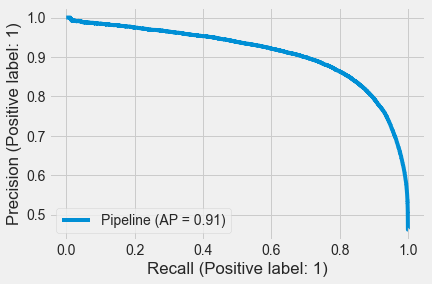

In [24]:
models['log_model'] = get_score(X_test, y_test, log_pipeline)

## TfIdf + Xgboost

In [25]:
xgb_params = {
    'n_estimators': 1000,
    'eta': 0.03, 
    'max_depth': 9, 
    'objective': 'binary:logistic', 
    'eval_metric': 'auc',
    'seed': 23
}
xgb_model = XGBClassifier(**xgb_params)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('xgbclf', xgb_model),
])

In [26]:
X_train_transformed = pipeline[:-1].fit_transform(X_train)
x_valid_transformed = pipeline[:-1].transform(X_valid)

pipeline[-1].fit(
    X=X_train_transformed,
    y=y_train,
    eval_set=[(x_valid_transformed, y_valid)],
    early_stopping_rounds=30,
    verbose=50
)

pipeline.score(X_test, y_test)

[0]	validation_0-auc:0.66410
[50]	validation_0-auc:0.79819
[100]	validation_0-auc:0.83135
[150]	validation_0-auc:0.84947
[200]	validation_0-auc:0.86246
[250]	validation_0-auc:0.87082
[300]	validation_0-auc:0.87677
[350]	validation_0-auc:0.88188
[400]	validation_0-auc:0.88545
[450]	validation_0-auc:0.88915
[500]	validation_0-auc:0.89199
[550]	validation_0-auc:0.89455
[600]	validation_0-auc:0.89699
[650]	validation_0-auc:0.89885
[700]	validation_0-auc:0.90084
[750]	validation_0-auc:0.90250
[800]	validation_0-auc:0.90392
[850]	validation_0-auc:0.90524
[900]	validation_0-auc:0.90643
[950]	validation_0-auc:0.90752
[999]	validation_0-auc:0.90841


0.8265565118603364

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     74954
           1       0.86      0.74      0.80     64123

    accuracy                           0.83    139077
   macro avg       0.83      0.82      0.82    139077
weighted avg       0.83      0.83      0.83    139077



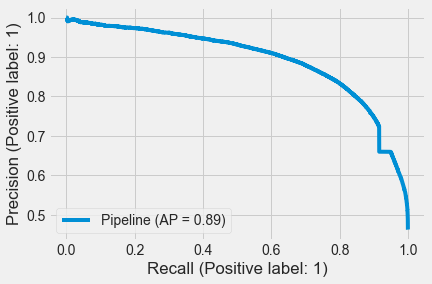

In [27]:
models['xgb_model'] = get_score(X_test, y_test, pipeline)

# Fasttext

In [29]:
train_fasttext = train
train_fasttext.target = train_fasttext.target.apply(lambda x: f'__class__{x}')
train_fasttext.to_csv(DATA_PATH + 'train_fasttext.csv', index=False, sep='\t')

test_fasttext = test
test_fasttext.target = test_fasttext.target.apply(lambda x: f'__class__{x}')
test_fasttext.to_csv(DATA_PATH + 'test_fasttext.csv', index=False, sep='\t')

In [30]:
model = train_supervised(
    input='train_fasttext.csv', 
    label="__class__", 
    lr=1.0, 
    epoch=25, 
    loss='hs', 
    wordNgrams=2,
    verbose=5
)

In [31]:
pred = X_test.apply(lambda x: model.predict(x, k=2)[1][1])
print(classification_report(y_test, (pred > 0.01).astype(int)))
roc_auc = roc_auc_score(y_test, pred)
roc_auc

              precision    recall  f1-score   support

           0       0.56      0.78      0.65     74954
           1       0.52      0.28      0.36     64123

    accuracy                           0.55    139077
   macro avg       0.54      0.53      0.51    139077
weighted avg       0.54      0.55      0.52    139077



0.5684943738289889

In [32]:
models['fasttext_model'] = roc_auc

# Gensim word2vec + 

In [63]:
%%time

cores = multiprocessing.cpu_count() # Count the number of cores in a computer, important for a parameter of the model
w2v_model = Word2Vec(
    min_count=20,
    window=2,
    vector_size=300,
    sample=6e-5, 
    alpha=0.03, 
    min_alpha=0.0007, 
    negative=20,
    workers=cores-1,
    sg=1
)

#BUILD_VOCAB()
t = time()
w2v_model.build_vocab(train_txt, progress_per=1000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

#TRAIN()
w2v_model.train(train_txt, total_examples=w2v_model.corpus_count, epochs=20)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
# model_skipgram = word2vec.Word2Vec(sentences=train_txt, sg=1, min_count=10, workers=4, window =10, epochs = 20)

Time to build vocab: 0.04 mins
Time to train the model: 7.18 mins
Wall time: 7min 10s


In [74]:
train

,text,target
121201,utc britain briton expect fan liter iio ii apr...,__class__0
163241,feel sorri anonym troll great stori anger see ...,__class__1
50445,style background color fsfffa pad cellpad styl...,__class__0
1280502,font general avail design specif microsoft dif...,__class__0
460979,tie terror state inclin admiss suspect badg go...,__class__0
...,...,...
1812328,realiz requir use cmhc unless right see govern...,__class__0
28091,mayor year alreadi notic,__class__0
203154,richard watch step someon make defamatori clai...,__class__0
718369,alreadi happen canada exampl visit richmond bc...,__class__0


In [92]:
train_txt2 = train.text.progress_apply(
    lambda x: np.mean([w2v_model.wv[item] for item in x.split() if item in w2v_model.wv.index_to_key], axis=0)
)

  0%|          | 0/417227 [00:00<?, ?it/s]

In [ ]:
train_txt3 = train.text.progress_apply(
    lambda x: ' '.join(x)
).str.split(expand=True)

  0%|          | 0/417227 [00:00<?, ?it/s]

In [ ]:
train_txt3

In [104]:
pd.DataFrame(train_txt2).text

121201     [-0.23504572, -0.1628289, 0.07194646, 0.027465...
163241     [-0.095541336, 0.05911652, 0.0073583988, 0.075...
50445      [-0.10781052, -0.034164272, -0.079355605, 0.08...
1280502    [-0.14773302, 0.038502842, 0.023217581, 0.1152...
460979     [-0.06673203, -0.058793295, -0.027792728, 0.07...
                                 ...                        
1812328    [-0.0793452, 0.020325162, -0.068323314, 0.0504...
28091      [-0.20081818, 0.044199284, -0.006461583, 0.107...
203154     [-0.070924684, 0.06855943, -0.008553401, 0.093...
718369     [-0.11128843, 0.018442681, -0.036585573, 0.139...
87521      [-0.12610173, 0.042943902, -0.049508166, 0.045...
Name: text, Length: 417227, dtype: object

In [101]:
pd.DataFrame(train_txt2)

,text
121201,"[-0.23504572, -0.1628289, 0.07194646, 0.027465..."
163241,"[-0.095541336, 0.05911652, 0.0073583988, 0.075..."
50445,"[-0.10781052, -0.034164272, -0.079355605, 0.08..."
1280502,"[-0.14773302, 0.038502842, 0.023217581, 0.1152..."
460979,"[-0.06673203, -0.058793295, -0.027792728, 0.07..."
...,...
1812328,"[-0.0793452, 0.020325162, -0.068323314, 0.0504..."
28091,"[-0.20081818, 0.044199284, -0.006461583, 0.107..."
203154,"[-0.070924684, 0.06855943, -0.008553401, 0.093..."
718369,"[-0.11128843, 0.018442681, -0.036585573, 0.139..."


In [97]:
log_model2 = LogisticRegression(
    C=4.281332398719396, 
    penalty='l1',
    solver='liblinear'
)
log_model2.fit(train_txt2, y_train)

ValueError: setting an array element with a sequence.

In [ ]:
get_score(train_txt2, y_train, log_model2)

In [ ]:
# model.build_vocab(clean_sents, update=True)
# model.train(clean_sents, total_examples=model.corpus_count, epochs=5)

# Best Model

In [35]:
models

{'log_model': 0.9284148189569119,
 'xgb_model': 0.9097135944942707,
 'fasttext_model': 0.5684943738289889}

In [36]:
best_model = max(models, key=models.get)
best_model

'log_model'

In [39]:
# Сохраним модель
with open(MODEL_PATH + 'log_pipeline.pickle', 'wb') as f:
    pkl.dump(log_pipeline, f)

In [27]:
# Сохраним словарь частоты слов
with open(MODEL_PATH + 'models/vocab.pickle', 'wb') as f:
    pkl.dump(vocab, f)